# PyTorch hardware benchmark analysis

Single node throughput comparisons between different hardware options at NERSC.

In [1]:
import os
import re
import glob

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [4]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/

dgx-1.7.1-nccl-n1/   gpu-1.7.1-nccl-n64/        hsw-1.7.1-mpi-n2/
dgx-1.7.1-nccl-n2/   gpu-1.7.1-nccl-n8/         hsw-1.7.1-mpi-n32/
dgx-1.7.1-nccl-n4/   gpu-ngc-20.10-v0-nccl-n1/  hsw-1.7.1-mpi-n4/
dgx-1.7.1-nccl-n8/   gpu-v1.2.0-nccl-n1/        hsw-1.7.1-mpi-n64/
gpu-1.7.0-nccl-n1/   gpu-v1.3.1-nccl-n1/        hsw-1.7.1-mpi-n8/
gpu-1.7.1-gloo-n1/   gpu-v1.4.0-nccl-n1/        hsw-v1.2.0-mpi-n1/
gpu-1.7.1-gloo-n16/  gpu-v1.5.1-nccl-n1/        hsw-v1.3.1-mpi-n1/
gpu-1.7.1-gloo-n2/   gpu-v1.6.0-nccl-n1/        hsw-v1.4.0-mpi-n1/
gpu-1.7.1-gloo-n32/  hsw-1.7.1-gloo-n1/         hsw-v1.5.0-mpi-n1/
gpu-1.7.1-gloo-n4/   hsw-1.7.1-gloo-n16/        hsw-v1.6.0-mpi-n1/
gpu-1.7.1-gloo-n64/  hsw-1.7.1-gloo-n2/         knl-1.7.1-mpi-n1/
gpu-1.7.1-gloo-n8/   hsw-1.7.1-gloo-n32/        knl-1.7.1-mpi-n16/
gpu-1.7.1-nccl-n1/   hsw-1.7.1-gloo-n4/         knl-1.7.1-mpi-n2/
gpu-1.7.1-nccl-n16/  hsw-1.7.1-gloo-n64/        knl-1.7.1-mpi-n32/
gpu-1.7.1-nccl-n2/   hsw-1.7.1-gloo-n8/         knl-1.7.1-mpi-n4/
g

In [5]:
pattern = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/%s-%s-%s-n1/results.txt'
version = '1.7.1'

In [6]:
results_files = (
    glob.glob(pattern % ('hsw', version, 'mpi')) +
    glob.glob(pattern % ('knl', version, 'mpi')) + 
    glob.glob(pattern % ('gpu', version, 'nccl')) +
    glob.glob(pattern % ('dgx', version, 'nccl'))
)
results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/knl-1.7.1-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.1-nccl-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/dgx-1.7.1-nccl-n1/results.txt']

In [7]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

## Tables

### Full set of training and inference rates (samples/s) for configurations tested

In [8]:
results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,8.667265,34.391664,1,hsw,1.7.1,mpi,transformer
1,823.987637,1929.792356,1,hsw,1.7.1,mpi,lstm
2,209.991957,753.882725,1,hsw,1.7.1,mpi,alexnet
3,16.304242,55.684349,1,hsw,1.7.1,mpi,resnet50
4,46.387229,98.640427,1,hsw,1.7.1,mpi,cnn3d
5,5.854703,16.195197,1,knl,1.7.1,mpi,transformer
6,203.936679,577.553098,1,knl,1.7.1,mpi,lstm
7,172.926193,525.629263,1,knl,1.7.1,mpi,alexnet
8,9.559700,56.262870,1,knl,1.7.1,mpi,resnet50
9,22.123041,42.548305,1,knl,1.7.1,mpi,cnn3d


In [9]:
pd.set_option('precision', 2)

### Training rate per hardware

In [10]:
train_rates = results.groupby('model').apply(lambda g: pd.Series(data=g.train_rate.values, index=g.hardware))
train_rates

hardware,hsw,knl,gpu,dgx
model,,,,
alexnet,209.99,172.93,1953.33,2468.49
cnn3d,46.39,22.12,428.23,610.64
lstm,823.99,203.94,7364.04,12168.81
resnet50,16.30,9.56,328.16,428.87
transformer,8.67,5.85,263.92,595.29


### Training rates relative to Haswell

In [11]:
train_rates.apply(lambda x: x / train_rates.hsw)

hardware,hsw,knl,gpu,dgx
model,,,,
alexnet,1.0,0.82,9.30,11.76
cnn3d,1.0,0.48,9.23,13.16
lstm,1.0,0.25,8.94,14.77
resnet50,1.0,0.59,20.13,26.30
transformer,1.0,0.68,30.45,68.68


### Inference rates per hardware

In [12]:
inference_rates = results.groupby('model').apply(lambda g: pd.Series(data=g.inference_rate.values, index=g.hardware))
inference_rates

hardware,hsw,knl,gpu,dgx
model,,,,
alexnet,753.88,525.63,3581.43,3869.39
cnn3d,98.64,42.55,909.47,1581.46
lstm,1929.79,577.55,14140.86,22423.89
resnet50,55.68,56.26,999.52,1196.61
transformer,34.39,16.20,785.41,1961.05


### Inference rates relative to Haswell

In [13]:
inference_rates.apply(lambda x: x / inference_rates.hsw)

hardware,hsw,knl,gpu,dgx
model,,,,
alexnet,1.0,0.70,4.75,5.13
cnn3d,1.0,0.43,9.22,16.03
lstm,1.0,0.30,7.33,11.62
resnet50,1.0,1.01,17.95,21.49
transformer,1.0,0.47,22.84,57.02


## Training throughput barplots

In [14]:
#models = ['alexnet', 'vgg11', 'inceptionV3', 'resnet50', 'cnn3d', 'lstm']
models = ['alexnet', 'resnet50', 'cnn3d', 'lstm', 'transformer']
results_by_model = results.groupby('model')

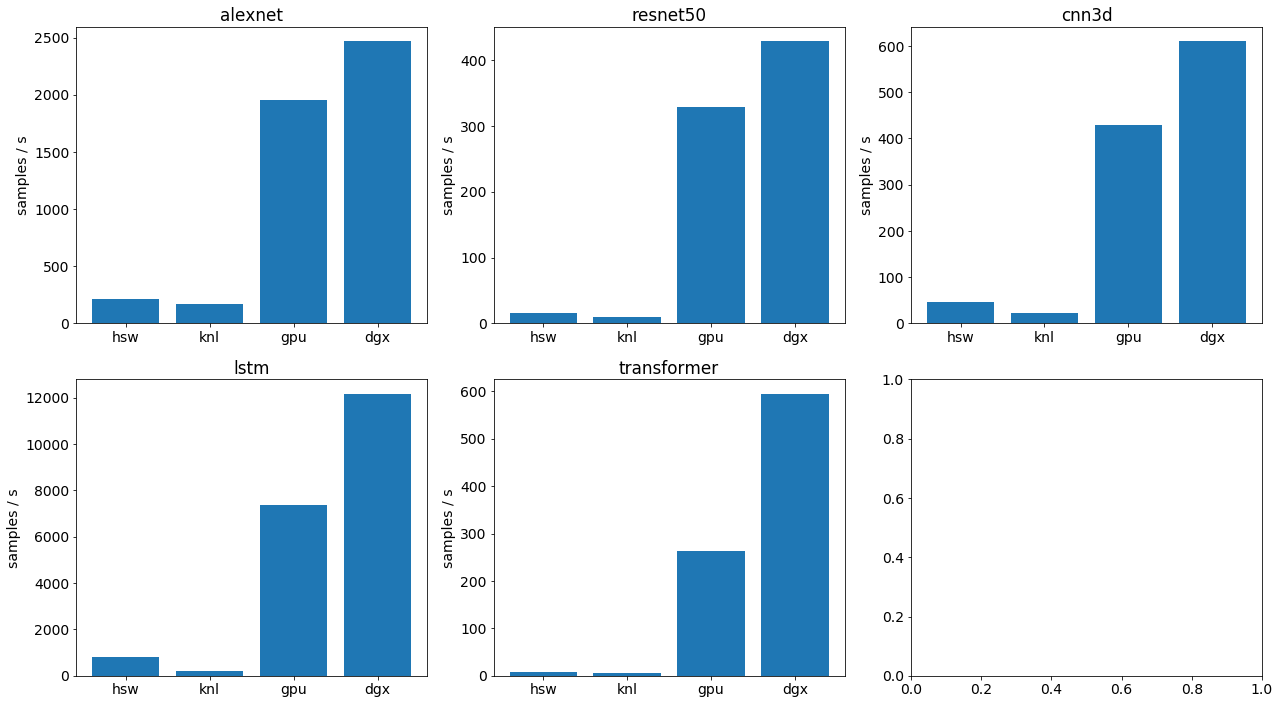

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, model in enumerate(models):
    ax = axs[i]
    model_results = results_by_model.get_group(model)
    ax.bar(model_results.hardware, model_results.train_rate, log=False)
    ax.set_title(model)
    ax.set_ylabel('samples / s')

plt.tight_layout()